# Feature Analysis

In [1]:
import pandas as pd
import math
import zipfile
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
smear_e = 1
pt_min = 0.3
ep_min = 0.1

In [3]:
filepath = "/home/yoren/bnl/PHENIX/ee/ML/newsim/"
filenames2 = ['dalitz_100M_v0.zip','dalitz_100M_v1.zip','dalitz_100M_v2.zip','dalitz_100M_v3.zip','dalitz_100M_v4.zip']
filenames1 = ['pionminus_05_100M_v0.zip','pionminus_05_100M_v1.zip','pionminus_05_100M_v2.zip','pionminus_05_100M_v3.zip',\
              'pion_plus_05_100M_v0.zip','pion_plus_05_100M_v1.zip','pion_plus_05_100M_v2.zip','pion_plus_05_100M_v3.zip',\
              'pionminus_100M_v0.zip', 'pionminus_100M_v1.zip', 'pionminus_100M_v2.zip', 'pionminus_100M_v3.zip',\
              'pionplus_100M_v0.zip', 'pionplus_100M_v1.zip', 'pionplus_100M_v2.zip', 'pionplus_100M_v3.zip']
filenames1 = [\
              'pionminus_100M_v0.zip', 'pionminus_100M_v1.zip', 'pionminus_100M_v2.zip', 'pionminus_100M_v3.zip',\
              'pionplus_100M_v0.zip', 'pionplus_100M_v1.zip', 'pionplus_100M_v2.zip', 'pionplus_100M_v3.zip']
n_e_tot = 50e6
n_h_tot = 200e6

In [4]:
#filepath = "/home/yoren/bnl/PHENIX/ee/ML/newsim/"
#filenames2 = ['dalitz_100M_v0.zip']
#filenames1 = ['pionminus_100M_v0.zip','pionplus_100M_v0.zip']
#n_e_tot = 10e6
#n_h_tot = 50e6

In [5]:
def read_csvs_from_zip(zpath):
    """Return a single DataFrame by concatenating all CSVs inside zpath."""
    dfs = []
    with zipfile.ZipFile(zpath) as z:
        # pick only CSV files (ignore folders/others)
        csv_names = [n for n in z.namelist() if n.lower().endswith(".csv") and not n.endswith("/")]
        if not csv_names:
            print(f"[warn] no CSVs found in {zpath}")
        for name in csv_names:
            with z.open(name) as f:
                dfs.append(pd.read_csv(f))
    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

def ensure_zip_path(filepath, base):
    """Build a .zip path even if base already has extension."""
    if base.lower().endswith(".zip"):
        return os.path.join(filepath, base)
    else:
        return os.path.join(filepath, f"{base}.zip")

# --- build data1 (phi0 = 0) ---
zpath = ensure_zip_path(filepath, filenames1[0])
data1 = read_csvs_from_zip(zpath)
data1["phi0"] = 0

for ifile in range(1, len(filenames1)):
    zpath = ensure_zip_path(filepath, filenames1[ifile])
    idata = read_csvs_from_zip(zpath)
    if not idata.empty:
        idata["phi0"] = 0
        print(idata.shape[0])
        data1 = pd.concat([data1, idata], ignore_index=True, sort=False)

# --- build data2 (phi0 = 1) ---
zpath = ensure_zip_path(filepath, filenames2[0])
data2 = read_csvs_from_zip(zpath)
data2["phi0"] = 1

for ifile in range(1, len(filenames2)):
    zpath = ensure_zip_path(filepath, filenames2[ifile])
    idata = read_csvs_from_zip(zpath)
    if not idata.empty:
        idata["phi0"] = 1
        data2 = pd.concat([data2, idata], ignore_index=True, sort=False)



2647126
2644614
2429134
2634356
2633205
2631738
2435765


In [6]:
data1['weight'] = data1['weight'] / n_h_tot * 1e8
data2['weight'] = data2['weight'] / n_e_tot * 1e8

In [7]:
data2.shape

(16433283, 16)

In [8]:
data2 = data2[ (data2['pt'] < 1.1 * data2['pt_gen']) ]

In [9]:
data2.shape

(16386256, 16)

In [10]:
# --- merge, filter, shuffle ---
data = pd.concat([data1, data2], ignore_index=True, sort=False)
data = data[(data["pt"] > pt_min) & (data["pt"] < 25) & (data["n0"] > -1)]

In [14]:
# shuffle for ML
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

In [15]:
data.head()

centrality        pt         p     ecore  n0      disp       chi2  npe0  \
0          42  8.456941  8.697697  0.565455   3  2.017674  55.454094     5   
1          30  1.232277  1.264735  1.099999   2  1.943507  45.283226     5   
2          63  0.499509  0.519284  0.504005   3  5.511457  21.499823     4   
3          25  4.816895  4.993959  4.602363   1  5.426560  69.192909     2   
4          11  0.879049  0.890942  0.784719   4  2.999490  24.334169     8   

   sector      prob   emcdphi     emcdz  Q    pt_gen    weight  phi0  
0       2  0.319210 -0.004219  3.517029 -1  8.750094  0.000181     0  
1       0  0.300356 -0.006904 -1.648895  1  5.954147  0.000296     1  
2       4  0.943600  0.002910  0.935440 -1  2.714426  0.009866     1  
3       2  0.714267 -0.002310 -1.923828  1  4.738905  0.033087     0  
4       7  0.902011  0.005774 -0.324677  1  4.031712  0.008357     1

In [16]:
data['e/p']=data['ecore']/data['p']
data['chi2/npe0']=data['chi2']/data['npe0']

In [17]:
data = data[(data["e/p"] > ep_min)]

In [18]:
import numpy as np

if smear_e:
    mom_scale  = 0.981  # B-field scale
    scale   = np.array([0.988, 0.990, 0.985, 0.981, 0.980, 0.985, 1.025, 1.023])
    smear_c1 = np.array([0.055, 0.066, 0.055, 0.059, 0.057, 0.056, 0.072, 0.072])
    smear_c2 = np.array([0.011, 0.017, 0.011, 0.013, 0.012, 0.012, 0.063, 0.062])
    pt_smear = 0.025 # in %

    n = len(data)
    rand = np.random.normal(size=n)
    rand1 = np.random.normal(size=n)

    # Randomly pick ONE index for the whole sample (as in your code).
    # If you meant one per row, see the note below.
    sector = data['sector'].to_numpy()
    pt     = data['pt'].to_numpy()
    ecore = data['ecore'].to_numpy()

    # Avoid divide-by-zero in the smearing term
    eps = 1e-12
    smear_sigma = np.sqrt(smear_c1[sector]**2 + (smear_c2[sector] / np.sqrt(np.maximum(ecore, eps)))**2)
    smear_pt = 1.0 + pt_smear * rand1

    # Apply momentum scale and e/p smearing (in-place on DataFrame)
    data['pt']  = mom_scale * data['pt'] * smear_pt
    data['e/p'] = data['e/p'] / mom_scale * (1.0 + rand * smear_sigma)


In [19]:
if True:
    data['disp2'] = data['n0']-data['disp']*data['disp']/8.
    data['emcdphi'] = (data['emcdphi'].abs() < 0.02).astype(np.int8)
    data['emcdz'] = ( (data['emcdz'] - 1).abs() < 8 ).astype(np.int8)
    data['centr+pt'] = data['centrality']/20.+data['pt']*data['pt']
    data['chi2/npe0'] = (data['chi2/npe0'].abs() < 10).astype(np.int8)

if False:
    data['disp2'] = data['n0']-data['disp']*data['disp']/8.
    data['centr+pt'] = data['centrality']/20.+data['pt']*data['pt']
    data['n0*pt'] = data['n0']+4*data['pt']
    data['e/p*pt'] = 1./((data['e/p']-0.9)*(data['e/p']-0.9)+0.25)/(1.25-data['prob'])+4*data['pt']
if False:
    data['disp2'] = data.apply(lambda row: row['n0']-row['disp']**2, axis=1)
    data['chi2/npe0'] = data.apply(lambda row: row['chi2']/(row['npe0']+0.001), axis=1)
    #data['e/p*prob'] = data.apply(lambda row:  1./(abs(row['e/p']-0.9)+0.25)/(1.25-row['prob']), axis=1)
    #data['n0*prob'] = data.apply(lambda row: (row['n0']-2)/(1.00001-row['prob']), axis=1)
    data['centr+pt'] = data.apply(lambda row: row['centrality']/20.+row['pt']*2, axis=1)
    data['e/p*pt'] = data.apply(lambda row: row['n0']+4*row['pt'], axis=1)
    data['n0*pt'] = data.apply(lambda row: 1./(abs(row['e/p']-0.9)+0.25)/(1.25-row['prob'])+4*row['pt'], axis=1)

In [20]:
data = data[( (data["e/p"] > 0.5) & (data["emcdz"] > 0) ) | (data['pt'] < 4.6)]

In [21]:
def discretize_ep(ep: pd.Series):
    conds = [
        (ep < 0.4),
        (ep >= 0.4) & (ep < 0.5),
        (ep >= 0.5) & (ep < 0.6),
        (ep > 0.6) & (ep < 1.1),
        (ep > 0.6) & (ep < 1.2),
        (ep > 0.6) & (ep < 1.4),
        (ep >= 0.6),   # last: general catch-all
    ]
    choices = [0, 1, 2, 6, 5, 4, 3]

    return np.select(conds, choices, default=-1)

data['e/p'] = discretize_ep(data['e/p'])


In [22]:
# удалим лишние колонки
#data = data.drop(columns = ['zdc','emcdphi','emcdz'])
data = data.drop(columns = ['p','pt_gen','chi2'])

In [27]:
data.head(20)

centrality        pt     ecore  n0      disp  npe0  sector      prob  \
1           30  1.200297  1.099999   2  1.943507     5       0  0.300356   
2           63  0.488893  0.504005   3  5.511457     4       4  0.943600   
3           25  4.776904  4.602363   1  5.426560     2       2  0.714267   
4           11  0.843414  0.784719   4  2.999490     8       7  0.902011   
5           24  5.976003  5.806980   4  2.136135     7       1  0.996479   
7           16  1.075710  0.922578   4  2.082587    10       4  0.022279   
9           12  2.380897  2.489666   1  5.320738     3       3  0.082858   
10          78  0.644746  0.549396   4  3.080209    15       6  0.524569   
13           3  0.602465  0.711892   4  3.548219    11       4  0.240859   
14          60  1.510139  1.408240   4  2.836526     7       1  0.990024   
15          47  1.066293  0.923475   2  3.602361     3       7  0.374226   
17          46  0.607700  0.667236   3  5.162073     5       5  0.878503   
19          65  7.595906  4.555358   3  2.779413     6       3  0.000058   
20          23  0.321190  0.211528   3  2.464973     7       2  0.323871   
22          79  1.440554  1.555769   6  2.084011    17       5  0.333716   
24          81  0.840112  0.912229   2  5.182566     7       7  0.725225   
25          12  1.538825  1.672952   3  2.525867    11       7  0.792801   
26          25  0.488889  0.467837   2  1.198444     8       3  0.792037   
27          54  0.503323  0.467829   5  1.177432     6       6  0.794193   
29          26  7.868883  5.625699   3  3.905425     6       0  0.080771   

    emcdphi  emcdz  Q      weight  phi0  e/p  chi2/npe0     disp2   centr+pt  
1         1      1  1    0.000296     1    6          1  1.527848   2.940713  
2         1      1 -1    0.009866     1    6          1 -0.797020   3.389016  
3         1      1  1    0.033087     0    6          0 -2.680945  24.068811  
4         1      1  1    0.008357     1    6          1  2.875382   1.261347  
5         1      1 -1    0.000009     1    6          1  3.429616  36.912613  
7         1      1  1  282.625585     0    6          0  3.457854   1.957153  
9         1      1 -1    0.000059     1    6          0 -2.538782   6.268669  
10        1      1 -1    0.000020     1    6          1  2.814039   4.315698  
13        1      1  1    0.000348     1    5          1  2.426268   0.512964  
14        1      1  1    0.000800     1    6          1  2.994265   5.280521  
15        1      1  1    0.009064     1    6          1  0.377874   3.486980  
17        1      1 -1    0.210198     1    5          0 -0.330875   2.669299  
19        1      1 -1    0.000072     0    6          1  2.034358  60.947783  
20        1      0  1    0.412693     1    6          1  2.240489   1.253163  
22        1      1 -1    0.000029     1    6          1  5.457112   6.025197  
24        1      1 -1    0.000004     1    6          1 -1.357373   4.755788  
25        1      1  1    0.000023     1    6          0  2.202499   2.967983  
26        1      1 -1    0.304475     1    6          0  1.820467   1.489013  
27        1      1 -1    0.003525     1    6          1  4.826707   2.953334  
29        1      1 -1    0.000676     0    6          1  1.093457  63.219320

In [28]:
print(data.size, data.shape)

302020062 (17765886, 17)


In [29]:
def analysis(data: pd.DataFrame):
    fig, ax = plt.subplots(3, 3, figsize=(15, 6))
    
    features = ['centrality', 'pt', 'e/p', 'n0', 'disp', 'chi2/npe0', 'Q', 'prob', 'phi0']
    
    # Define (min, max, bins) for each feature
    ranges = [
        (0, 100, 50),   # centrality
        (0, 10, 50),    # pt
        (0, 2, 40),     # e/p
        (0, 12, 24),    # n0
        (0, 10, 40),    # disp
        (0, 1, 40),     # chi2/npe0
        (-1, 1, 40),    # Q
        (0, 1, 40),     # prob
        (0, 1, 40),     # phi0
    ]
    
    for i, feature in enumerate(features):
        x, y = divmod(i, 3)
        ax_here = ax[x][y]
        xmin, xmax, nbins = ranges[i]
        
        bins = np.linspace(xmin, xmax, nbins+1)
        ax_here.hist(
            data[feature],
            bins=bins,
            color="skyblue",
            log=True,
            weights=data['weight']  # <-- apply weights
        )
        
        ax_here.set_xlim(xmin, xmax)
        ax_here.set_title(feature)
        ax_here.set_ylabel('')
    
    plt.tight_layout()
    return fig, ax

(<Figure size 1500x600 with 9 Axes>,
 array([[<Axes: title={'center': 'centrality'}>,
         <Axes: title={'center': 'pt'}>, <Axes: title={'center': 'e/p'}>],
        [<Axes: title={'center': 'n0'}>, <Axes: title={'center': 'disp'}>,
         <Axes: title={'center': 'chi2/npe0'}>],
        [<Axes: title={'center': 'Q'}>, <Axes: title={'center': 'prob'}>,
         <Axes: title={'center': 'phi0'}>]], dtype=object))

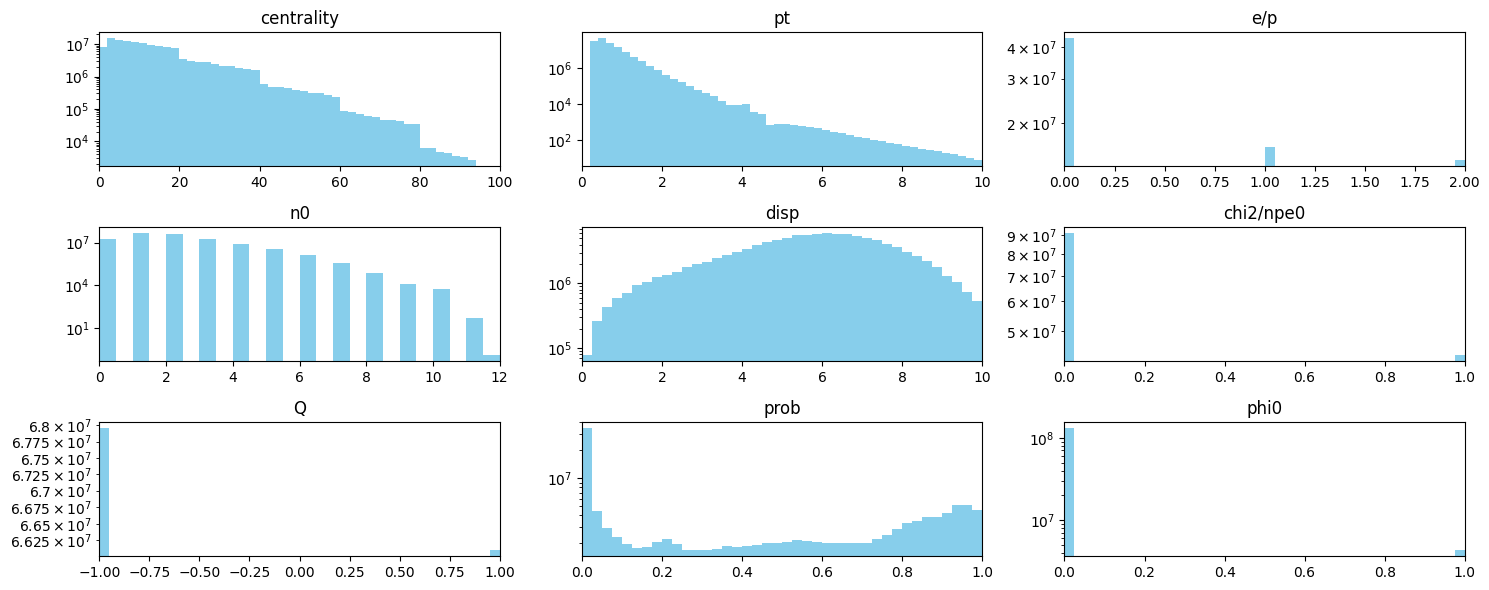

In [30]:
analysis(data)

+ Видим, что impressions имеют только одно значение, поэтому их можно удалить.
+ Таргет-переменная clicks сильно несбалансирована. Возможно, стоит использовать балансировку весов, а также в качестве оценки моделей использовать f1 и ROC AUC.
+ У campaign_clicks нулевых значений сильно больше, чем ненулевых, следовательно, можно трансформировать в бинарную фичу
+ os_id со значениями больше 6 встречается редко, можно объединить в одну категорию
+ Аналогично с редкими значениями zone_id

# Feature Engineering

In [31]:
def feature_engineering(data: pd.DataFrame) -> pd.DataFrame:

    cut_off_val =  int (data.shape[0]/3)
    cut_off_test = int (data.shape[0]/3*2 + 1)

    print(cut_off_val,cut_off_test)
    kek_data = data[cut_off_test:]
    y = data['phi0']
    w = data['weight']
    data = data.drop(columns = ['weight'])
    data = data.drop(columns = ['phi0'])
    data_train, data_test = data[:cut_off_test], data[cut_off_test:]
    y_train, y_test = y.iloc[:cut_off_test], y.iloc[cut_off_test:]
    w_train, w_test = w.iloc[:cut_off_test], w.iloc[cut_off_test:]

    return data_train, data_test, y_train, y_test, w_train, w_test, cut_off_val, kek_data

In [32]:
X_train_all, X_test, y_train_all, y_test, w_train_all, w_test, cut_off_val, kek_data = feature_engineering(data)

5921962 11843925


In [33]:
X_test

centrality        pt     ecore  n0      disp  npe0  sector  \
23677384          26  1.015942  1.090600   4  4.423733     7       3   
23677386          49  2.843558  3.211028   4  4.944244    11       1   
23677391          64  1.164421  1.157423   5  2.623309     8       5   
23677392          50  1.567142  1.476508   4  2.356025     6       3   
23677394          39  1.226138  1.150260   4  1.002918    10       6   
...              ...       ...       ...  ..       ...   ...     ...   
35522422          67  0.725040  0.623106   3  2.909873     5       6   
35522423          47  0.471239  0.438236   5  1.922245    15       0   
35522424          28  0.394791  0.437222   3  2.763256     6       2   
35522425          70  3.381388  3.068826   5  1.447288     7       3   
35522426          83  2.932380  3.352132   5  1.233789    10       2   

              prob  emcdphi  emcdz  Q  e/p  chi2/npe0     disp2   centr+pt  
23677384  0.935283        1      1 -1    6          0  1.553824   2.332138  
23677386  0.492641        1      0  1    5          1  0.944306  10.535820  
23677391  0.903193        1      1 -1    6          1  4.139781   4.555876  
23677392  0.859599        1      1 -1    6          0  3.306144   4.955934  
23677394  0.968276        1      1 -1    6          1  3.874270   3.453414  
...            ...      ...    ... ..  ...        ...       ...        ...  
35522422  0.984237        1      1 -1    6          1  1.941580   3.875683  
35522423  0.987441        1      1  1    6          1  4.538122   2.572066  
35522424  0.966111        1      1  1    6          1  2.045552   1.555860  
35522425  0.928147        1      1 -1    6          1  4.738170  14.933785  
35522426  0.850658        1      1  1    6          1  4.809721  12.748853  

[5921961 rows x 15 columns]

In [34]:
X_train, X_val = X_train_all, X_train_all[cut_off_val:]
y_train, y_val = y_train_all, y_train_all[cut_off_val:]
w_train, w_val = w_train_all, w_train_all[cut_off_val:]

+ Увидели, что количество кликов меняется в зависимости от дня недели и часа, добавим в качестве фичей
+ Также, добавим интеракции между этими двумя переменными, так как в разные дни недели разные часы могут по-разному влиять на колличество кликов
+ banner_id удалила, так как предполагаю, что модель должна уметь предсказывать клики для новых баннеров тоже.
+ Так как все оставшиеся фичи являются категориальными, сделали one-hot-encoding


+ В качестве теста берем последний день датасета, в качестве валидации -- предпоследний

# Create Model

In [35]:
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
gb_clf = GradientBoostingClassifier(n_estimators=2, learning_rate= 0.1, max_features=2, max_depth=2, random_state=0)
gb_clf.fit(X_train, y_train, w_train)

predicted = gb_clf.predict(X_test)

# calculating the main quality metrics
print(metrics.classification_report(y_test, predicted))

print('confusion matrix')
print(metrics.confusion_matrix(y_test, predicted))

/home/yoren/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/yoren/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/yoren/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.19      1.00      0.32   1146729
           1       0.00      0.00      0.00   4775232

    accuracy                           0.19   5921961
   macro avg       0.10      0.50      0.16   5921961
weighted avg       0.04      0.19      0.06   5921961

confusion matrix
[[1146729       0]
 [4775232       0]]


In [36]:
if False:
    # search for parameters
    # https://www.kaggle.com/hatone/gradientboostingclassifier-with-gridsearchcv
    import time
    from sklearn.model_selection import GridSearchCV
    
    start = time.time() 
    
    parameters = {
        "loss":["log_loss"],
        "learning_rate": [0.2],
        "min_samples_split": [0.01],
        "max_depth":[10],
        "max_features":["sqrt"],
        "criterion": ['squared_error'],
        "n_estimators":[10]
        }
    
    classif = GradientBoostingClassifier()
    classif.set_params(init='zero')
    
    clf = GridSearchCV(classif, parameters, cv=3, n_jobs=3)
    
    clf.fit(X_train, y_train, sample_weight=w_train)
    print('точность: ', clf.score(X_test, y_test))
    
    # getting the best parameters ans score
    print(clf.best_params_)
    print(clf.best_score_)
    
    stop = time.time()    
    print('time of execution (sec)', stop - start)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier

# --- weighted metric ---
def tpr2_over_fpr_thresh(y_true, y_proba, fpr_max=0.05, tpr_min=0.33, sample_weight=None):
    fpr, tpr, _ = roc_curve(y_true, y_proba, sample_weight=sample_weight)
    mask = np.ones_like(fpr, dtype=bool)
    if fpr_max is not None:
        mask &= (fpr <= fpr_max)
    if tpr_min is not None:
        mask &= (tpr >= tpr_min)
    if not np.any(mask):
        return 0.0, 0.0, 0.0
    fpr, tpr = fpr[mask], tpr[mask]
    j_values = (tpr**1) / np.maximum(fpr, 1e-12)
    idx = int(np.argmax(j_values))
    return float(j_values[idx]), float(tpr[idx]), float(fpr[idx])

# --- scorer factory that injects weights by aligning on the validation index ---
def make_weighted_scorer(w_series: pd.Series, fpr_max=0.05, tpr_min=0.33):
    """w_series must be a pandas Series indexed like y_train."""
    def _score(estimator, X, y):
        # Ensure y is a Series with index; if it's a ndarray, try to use X's index
        if not isinstance(y, pd.Series) and hasattr(X, "index"):
            y_idx = X.index
        else:
            y_idx = getattr(y, "index", None)

        # Pull fold weights by index if possible
        sw = None
        if y_idx is not None:
            try:
                sw = w_series.loc[y_idx].to_numpy()
            except Exception:
                sw = None

        proba = estimator.predict_proba(X)[:, 1]
        score, _, _ = tpr2_over_fpr_thresh(y, proba, fpr_max=fpr_max, tpr_min=tpr_min, sample_weight=sw)
        return score
    return _score


# ---- ensure weights are a pandas Series aligned to X_train/y_train ----
# Example:
# X_train: DataFrame, y_train: Series, w_train: Series with same index
assert isinstance(X_train, pd.DataFrame), "Pass X_train as a pandas DataFrame."
assert isinstance(y_train, pd.Series), "Pass y_train as a pandas Series."
assert isinstance(w_train, pd.Series), "Pass w_train as a pandas Series."
assert X_train.index.equals(y_train.index) and y_train.index.equals(w_train.index), "Indices must match."

weighted_scorer = make_weighted_scorer(w_train, fpr_max=0.05, tpr_min=0.49)

def weighted_scorer(estimator, X, y):
    proba = estimator.predict_proba(X)[:, 1]
    # align weights however you need (global variable or closure-safe)
    sw = w_train.loc[X.index].to_numpy() if hasattr(X, "index") else None
    score, _, _ = tpr2_over_fpr_thresh(y, proba, fpr_max=0.05, tpr_min=0.33, sample_weight=sw)
    return score

# ---- your grid (kept as-is) ----
parameters = {
    "loss": ["log_loss","exponential"],
    "learning_rate": [0.2,0.05],
    "min_samples_split": [0.001,0.01],
    "max_depth": [15,10],
    "max_features": ["log2"],
    "criterion": ["squared_error"],
    "n_estimators": [15,10],
}

classif = GradientBoostingClassifier()
classif.set_params(init='zero')

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

clf = GridSearchCV(
    estimator=classif,
    param_grid=parameters,
    scoring=weighted_scorer,   # <-- callable scorer with weights
    refit=True,
    cv=cv,
    n_jobs=4,
    verbose=0,
)

clf.fit(X_train, y_train, sample_weight=w_train)
#print("точность: ", clf.score(X_test, y_test))  # unweighted scoring on test unless we build another scorer

best_gb = clf.best_estimator_

# Recompute full weighted metric on TEST set
y_scores = best_gb.predict_proba(X_test)[:, 1]
# If you have w_test as Series aligned to X_test:
score, best_tpr, best_fpr = tpr2_over_fpr_thresh(
    y_test, y_scores, fpr_max=0.05, tpr_min=0.49,
    sample_weight=(w_test if isinstance(w_test, (pd.Series, np.ndarray)) else None)
)

print("Best params:", clf.best_params_)
print(f"Best custom score (TPR^2/FPR): {score:.4f}")
print(f"Corresponding TPR: {best_tpr:.4f}, FPR: {best_fpr:.4e}")

KeyError: "None of [Index([23677384, 23677386, 23677391, 23677392, 23677394, 23677395, 23677396,\n       23677397, 23677398, 23677399,\n       ...\n       35522413, 35522417, 35522419, 35522420, 35522421, 35522422, 35522423,\n       35522424, 35522425, 35522426],\n      dtype='int64', length=5921961)] are in the [index]"

In [264]:

# Recompute full weighted metric on TEST set
y_scores = best_gb.predict_proba(X_test)[:, 1]
# If you have w_test as Series aligned to X_test:
score, best_tpr, best_fpr = tpr2_over_fpr_thresh(
    y_test, y_scores, fpr_max=0.05, tpr_min=0.49,
    sample_weight=(w_test if isinstance(w_test, (pd.Series, np.ndarray)) else None)
)

print("Best params:", clf.best_params_)
print(f"Best custom score (TPR^2/FPR): {score:.4f}")
print(f"Corresponding TPR: {best_tpr:.4f}, FPR: {best_fpr:.4e}")

Best params: {'criterion': 'squared_error', 'learning_rate': 0.2, 'loss': 'exponential', 'max_depth': 15, 'max_features': 'log2', 'min_samples_split': 0.01, 'n_estimators': 15}
Best custom score (TPR^2/FPR): 100.3172
Corresponding TPR: 0.4904, FPR: 4.8886e-03


# Cross Validation

In [38]:
predicted = clf.predict(X_test)
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.41      0.93      0.57   1146729
           1       0.97      0.68      0.80   4775232

    accuracy                           0.73   5921961
   macro avg       0.69      0.80      0.68   5921961
weighted avg       0.86      0.73      0.76   5921961



   feature  importance
      npe0    0.176313
     disp2    0.170692
       e/p    0.142297
      disp    0.107270
      prob    0.080181
        pt    0.073459
centrality    0.056483
     ecore    0.055560
  centr+pt    0.037152
     emcdz    0.028397
 chi2/npe0    0.027985
   emcdphi    0.018686
        n0    0.013655
    sector    0.010971
         Q    0.000898


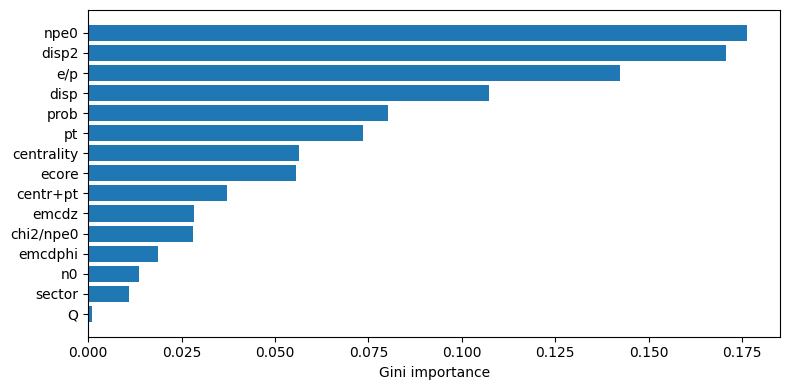

In [39]:
# --- Feature importance (tree-based GBDT) ---
feat_names = X_train.columns
gb_best = clf.best_estimator_          # GradientBoostingClassifier
imp = gb_best.feature_importances_

import pandas as pd
fi_df = pd.DataFrame({'feature': feat_names, 'importance': imp})
fi_df = fi_df.sort_values('importance', ascending=False)
print(fi_df.to_string(index=False))

# Optional: bar plot
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.barh(fi_df.feature[::-1], fi_df.importance[::-1])
plt.xlabel("Gini importance")
plt.tight_layout()
plt.show()

if False:##more precise but slow
    # --- Permutation importance (more reliable, model-agnostic) ---
    from sklearn.inspection import permutation_importance
    pi = permutation_importance(gb_best, X_test, y_test,
                                n_repeats=5, random_state=42,
                                n_jobs=3, sample_weight=w_test)
    pi_df = pd.DataFrame({'feature': feat_names,
                          'perm_importance_mean': pi.importances_mean,
                          'perm_importance_std': pi.importances_std})
    pi_df = pi_df.sort_values('perm_importance_mean', ascending=False)
    print(pi_df.to_string(index=False))

In [40]:
y_pred_probs = clf.predict_proba(X_test)
y_pred = clf.predict(X_test)

# Model Evaluation

log loss: 0.06741866237993083
roc auc: 0.9557572927855547
f1 score: 0.9265269925751816


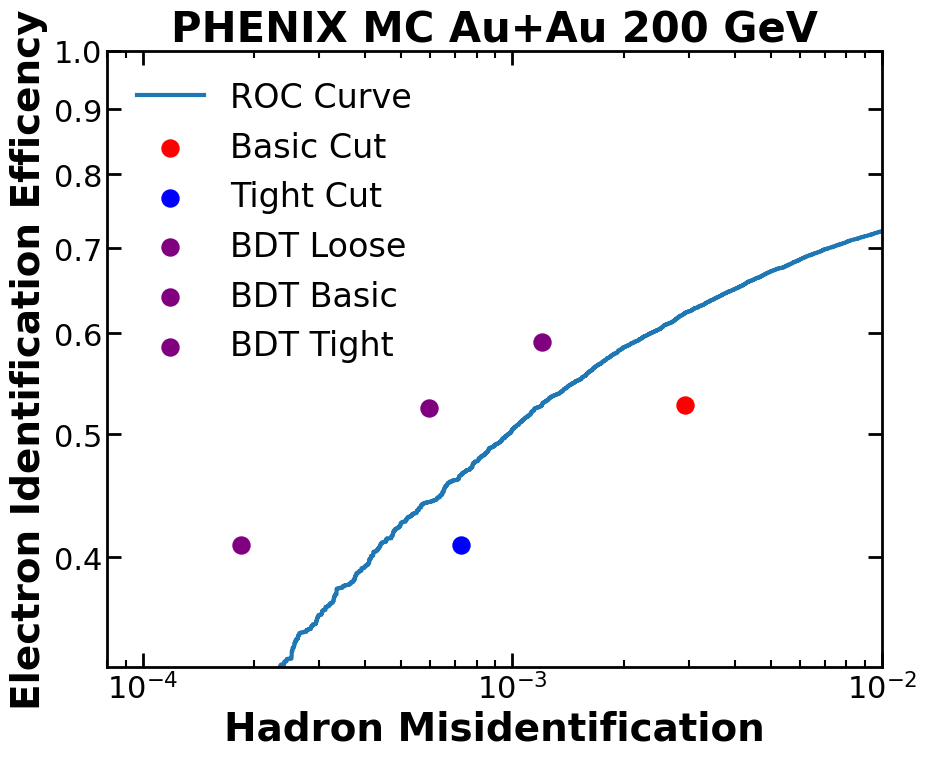

In [41]:
import numpy as np
from sklearn import metrics
from sklearn.metrics import roc_auc_score, log_loss, f1_score
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

print('log loss:', log_loss(y_test, y_pred_probs, sample_weight=w_test))

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs[:, 1], pos_label=1, sample_weight=w_test)
metrics.auc(fpr, tpr)
print('roc auc:', metrics.auc(fpr, tpr))

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
y_pred_opt = y_pred_probs[:, 1] > optimal_threshold
print('f1 score:', f1_score(y_test, y_pred_opt))

# Plot ROC curve
plt.figure(figsize=(10, 8))

rej = 25/2
eff = 0.8

fpr = fpr / rej
tpr = tpr *eff
# Plot curves with increased line width
plt.plot(fpr, tpr, label='ROC Curve', linewidth=3)
#plt.plot(fpr, fpr, label='Random Guess', linestyle='--', linewidth=3)

# Add larger points to the plot  # Increased size with `s`
plt.scatter(1/1.5/rej*0.055, eff*0.659, color='red', label='Basic Cut', s=150, zorder=5)
plt.scatter(1/1.5/rej*0.0136, eff*0.511, color='blue', label='Tight Cut', s=150, zorder=5)
plt.scatter(1/rej*0.0150, eff*0.738, color='purple', label='BDT Loose', s=150, zorder=5)
plt.scatter(1/rej*0.00745, eff*0.655, color='purple', label='BDT Basic', s=150, zorder=5)
plt.scatter(1/rej*0.0023, eff*0.511, color='purple', label='BDT Tight', s=150, zorder=5)

# Set both axes to logarithmic scale
plt.xscale('log')
plt.yscale('log')

# Set the same range for both axes
plt.xlim(1e-3/rej, 1/100)
plt.ylim(0.41*eff, 1*eff)

# Customize y-axis ticks explicitly
y_ticks = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
plt.yticks(y_ticks, fontsize=22)

# Disable scientific notation on the y-axis
ax = plt.gca()
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.get_major_formatter().set_useOffset(False)
ax.yaxis.get_major_formatter().set_scientific(False)

# Enable minor ticks and customize tick size
plt.minorticks_on()
ax.tick_params(axis='both', which='major', length=10, width=2, labelsize=22, direction='in', top=True, right=True)  # Major ticks
ax.tick_params(axis='both', which='minor', length=5, width=1.5, direction='in', top=True, right=True)  # Minor ticks

# Add labels with larger font size
plt.xlabel("Hadron Misidentification", fontsize=28, fontweight='bold')
plt.ylabel("Electron Identification Efficency", fontsize=28, fontweight='bold')
plt.xticks(fontsize=22)
plt.title('PHENIX MC Au+Au 200 GeV', fontsize=30, fontweight='bold')

# Customize legend with larger font size and no box
plt.legend(fontsize=24, loc='upper left', frameon=False)

# Thicker plot frame
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)

# Save the plot with a transparent background
plt.savefig("output/roc_auc_curve_new.pdf", bbox_inches='tight', transparent=True)

# Show the plot
plt.show()

log loss: 0.06741866237993083
roc auc: 0.9557572927855547
f1 score: 0.9265269925751816


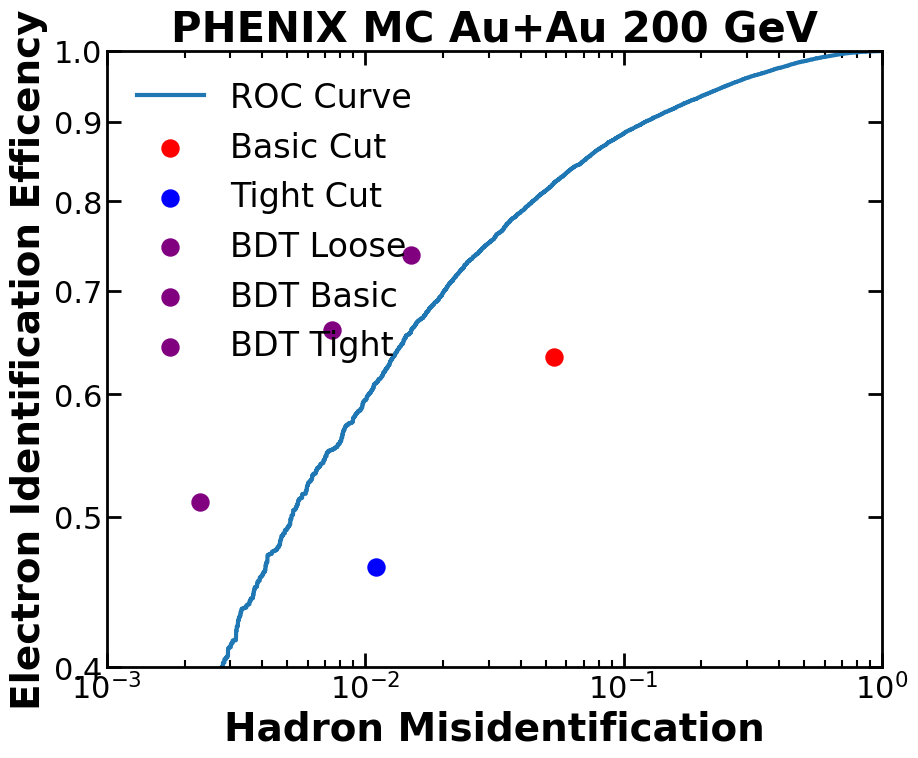

In [42]:
import numpy as np
from sklearn import metrics
from sklearn.metrics import roc_auc_score, log_loss, f1_score
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

print('log loss:', log_loss(y_test, y_pred_probs, sample_weight=w_test))

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs[:, 1], pos_label=1, sample_weight=w_test)
metrics.auc(fpr, tpr)
print('roc auc:', metrics.auc(fpr, tpr))

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
y_pred_opt = y_pred_probs[:, 1] > optimal_threshold
print('f1 score:', f1_score(y_test, y_pred_opt))

# Plot ROC curve
plt.figure(figsize=(10, 8))

rej = 1
eff = 1

fpr = fpr / rej
tpr = tpr *eff
# Plot curves with increased line width
plt.plot(fpr, tpr, label='ROC Curve', linewidth=3)
#plt.plot(fpr, fpr, label='Random Guess', linestyle='--', linewidth=3)

# Add larger points to the plot  # Increased size with `s`
plt.scatter(1/rej*0.054, eff*0.634, color='red', label='Basic Cut', s=150, zorder=5)
plt.scatter(1/rej*0.011, eff*0.464, color='blue', label='Tight Cut', s=150, zorder=5)
plt.scatter(1/rej*0.0150, eff*0.738, color='purple', label='BDT Loose', s=150, zorder=5)
plt.scatter(1/rej*0.00745, eff*0.66, color='purple', label='BDT Basic', s=150, zorder=5)
plt.scatter(1/rej*0.0023, eff*0.511, color='purple', label='BDT Tight', s=150, zorder=5)

# Set both axes to logarithmic scale
plt.xscale('log')
plt.yscale('log')

# Set the same range for both axes
plt.xlim(1e-3/rej, 1/rej/rej**0.5)
plt.ylim(0.41*eff, 1*eff)

# Customize y-axis ticks explicitly
y_ticks = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
plt.yticks(y_ticks, fontsize=22)

# Disable scientific notation on the y-axis
ax = plt.gca()
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.get_major_formatter().set_useOffset(False)
ax.yaxis.get_major_formatter().set_scientific(False)

# Enable minor ticks and customize tick size
plt.minorticks_on()
ax.tick_params(axis='both', which='major', length=10, width=2, labelsize=22, direction='in', top=True, right=True)  # Major ticks
ax.tick_params(axis='both', which='minor', length=5, width=1.5, direction='in', top=True, right=True)  # Minor ticks

# Add labels with larger font size
plt.xlabel("Hadron Misidentification", fontsize=28, fontweight='bold')
plt.ylabel("Electron Identification Efficency", fontsize=28, fontweight='bold')
plt.xticks(fontsize=22)
plt.title('PHENIX MC Au+Au 200 GeV', fontsize=30, fontweight='bold')

# Customize legend with larger font size and no box
plt.legend(fontsize=24, loc='upper left', frameon=False)

# Thicker plot frame
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)

# Save the plot with a transparent background
plt.savefig("output/roc_auc_curve_new_centr.pdf", bbox_inches='tight', transparent=True)

# Show the plot
plt.show()

In [43]:
pred_baseline = np.ones_like(y_test) * y_test.mean()
print("baseline auc:", roc_auc_score(y_test, pred_baseline))
print("baseline log_loss:", log_loss(y_test, pred_baseline))

baseline auc: 0.5
baseline log_loss: 0.49145827753048815


In [224]:
i = 2050000
print(round(fpr[i],3),round(tpr[i],4))
print(thresholds[i],fpr[i],tpr[i])
print(fpr[i]/tpr[i])
#print((fpr[i]/tpr[i]*data1.shape[0]/data2.shape[0]/10)**-1,(fpr[i]/1.*data1.shape[0]/data2.shape[0]/10)**-1)

0.005 0.4965
0.504722774424771 0.005123313141745373 0.4965158475359225
0.010318528939551534


In [225]:
print(sum(predicted),len(predicted))

3327056 5921961


In [226]:
#kek_data = data
#kek_data = kek_data.drop(columns = ['phi0'])
proba_loc = clf.predict_proba(X_test)
print(proba_loc[0][1])

0.442151434313825


In [227]:
import ROOT as root
outfile = root.TFile.Open("output/BDT_test1.root", "recreate")
e_pt_hist_AI = root.TH2D("e_pt_hist_AI", "e_pt_hist_AI", 100, 0, 10, 10, 0, 100)
h_pt_hist_AI = root.TH2D("h_pt_hist_AI", "h_pt_hist_AI", 100, 0, 10, 10, 0, 100)
e_pt_hist_SC = root.TH2D("e_pt_hist_SC", "e_pt_hist_SC", 100, 0, 10, 10, 0, 100)
e_pt_hist_TC = root.TH2D("e_pt_hist_TC", "e_pt_hist_TC", 100, 0, 10, 10, 0, 100)
h_pt_hist_SC = root.TH2D("h_pt_hist_SC", "h_pt_hist_SC", 100, 0, 10, 10, 0, 100)
h_pt_hist_TC = root.TH2D("h_pt_hist_TC", "h_pt_hist_TC", 100, 0, 10, 10, 0, 100)
e_pt_hist_NC = root.TH2D("e_pt_hist_NC", "e_pt_hist_NC", 100, 0, 10, 10, 0, 100)
h_pt_hist_NC = root.TH2D("h_pt_hist_NC", "h_pt_hist_NC", 100, 0, 10, 10, 0, 100)

In [228]:
mycute,mycuth,tcute,tcuth, AIcute, AIcuth = 0, 0, 0, 0, 0, 0
norm_e, norm_h = 0, 0
data0 = kek_data.reset_index()  # make sure indexes pair with number of rows

counter =-1
for index, row in data0.iterrows():
    counter+=1
    if counter>10000000: break
    centrality, pt, ep, n0, disp, chi2, npe0, prob, phi0 = row['centrality'], row['pt'], row['e/p'], row['n0'], row['disp'], row['chi2/npe0'], row['n0'], row['prob'], row['phi0']
    w = row['weight']/1e8
    if pt<pt_min or centrality<0: continue
    if phi0: e_pt_hist_NC.Fill(pt,centrality,w)
    else:    h_pt_hist_NC.Fill(pt,centrality,w)
    if ep>0.8 and n0>=2 and disp <5 and chi2<1: 
        if phi0: 
            mycute+=w
            e_pt_hist_SC.Fill(pt,centrality,w)
        else: 
            mycuth+=w
            h_pt_hist_SC.Fill(pt,centrality,w)

    if ep>0.8 and n0>=2 + disp**2/8 and disp <4 and prob>0.01 and chi2<1: 
        if phi0: 
            tcute+=w
            e_pt_hist_TC.Fill(pt,centrality,w)
        else: 
            tcuth+=w
            h_pt_hist_TC.Fill(pt,centrality,w)
    if proba_loc[counter][1]>thresholds[i]: 
        if phi0: 
            AIcute+=w
            e_pt_hist_AI.Fill(pt,centrality,w)
        else: 
            AIcuth+=w
            h_pt_hist_AI.Fill(pt,centrality,w)
    if phi0: norm_e+=w
    else: norm_h+=w
    #if counter<10: 
    #    print(proba_loc[counter],answer(centrality,pt,ep,n0,disp,chi2,npe0,prob))
        #print(centrality, pt, ep, n0, disp, chi2, npe0, prob, phi0 )

In [229]:
print(norm_e, norm_h, round(mycute/norm_e,3),round(mycuth/norm_h,3),round(tcute/norm_e,3),round(tcuth/norm_h,4), round(AIcute/norm_e,3), round(AIcuth/norm_h,3), round(AIcuth/AIcute/norm_h*norm_e,3),round(fpr[i],3),round(tpr[i],3))

0.013812567589868749 0.42213015323239444 0.181 0.088 0.08 0.0143 0.499 0.005 0.01 0.005 0.497


In [230]:
print(round(AIcute/mycute/(AIcuth/mycuth),3),round(AIcute/mycute,3),round(AIcuth/mycuth,3), round(30*AIcute/norm_e/AIcuth*norm_h), counter)

47.364 2.753 0.058 2919 5921960


In [231]:
%run input/Format.ipynb
%jsroot on

/home/yoren/.local/lib/python3.10/site-packages/nbformat/__init__.py:96: MissingIDFieldWarning: Cell is missing an id field, this will become a hard error in future nbformat versions. You may want to use `normalize()` on your notebooks before validations (available since nbformat 5.1.4). Previous versions of nbformat are fixing this issue transparently, and will stop doing so in the future.
  validate(nb)


In [232]:
c1 = root.TCanvas("c1","c1",1400,2500)
c1.Divide(2,5)
part_names_legend= [ "prompt e^{-} " , "#gamma#rightarrow e^{-} "]
centralities_legend = ["0-20%","20-40%","40-60%","60-80%","80-93%"]
legends = []
for icentr in range(5):

    c1.cd(1+2*icentr)
    root.gPad.SetLogy()
    e_pt_hist_NC.ProjectionX(f"e_pt_hist_NC_{icentr}").SetLineWidth(312)
    e_pt_hist_SC.ProjectionX(f"e_pt_hist_SC_{icentr}").SetLineWidth(3)
    e_pt_hist_AI.ProjectionX(f"e_pt_hist_AI_{icentr}").SetLineWidth(3)
    e_pt_hist_NC.SetLineColor(4)
    e_pt_hist_SC.SetLineColor(2)
    e_pt_hist_AI.SetLineColor(1)
    proj = e_pt_hist_NC.ProjectionX(f"e_pt_hist_NC_{icentr}",2*icentr+1,2*icentr+2)
    proj.SetMaximum(2e-1)
    proj.SetMinimum(2e-13)
    Format_Hist_total(proj, title_x="p_{T} [GeV]",  title_y="dN/dp_{T}", left=0.15, bottom=0.15, right=0.01, top=0.01,  Tsize=0.07,  Lsize=0.06,\
                      Mstyle=21,  Msize=2, Mcolor=4,  Lwidth=3,  Lcolor=4,  offset_x=1, offset_y=1, title="",  Malpha=1,  Lalpha=1)
    proj.Draw("Hist")
    phoj_s = e_pt_hist_SC.ProjectionX(f"e_pt_hist_SC_{icentr}",2*icentr+1,2*icentr+2)
    phoj_s.Draw("same H")
    e_pt_hist_AI.ProjectionX(f"e_pt_hist_AI_{icentr}",2*icentr+1,2*icentr+2).Draw("same H")

    legends.append(Draw_Legend_Title(0.65,0.65,0.95,0.95,part_names_legend[0]+centralities_legend[icentr],TextSize=0.08, align =22, LineWidth=0, Color=1,  alpha=0))
    legends[-1].AddEntry(phoj_s,"std","l")
    legends[-1].AddEntry(e_pt_hist_AI.ProjectionX(f"e_pt_hist_AI_{icentr}",2*icentr+1,2*icentr+2),"bdt","l")
    legends[-1].Draw("H")

    c1.cd(2+2*icentr)
    root.gPad.SetLogy()
    h_pt_hist_NC.ProjectionX(f"h_pt_hist_NC_{icentr}").SetLineWidth(3)
    h_pt_hist_SC.ProjectionX(f"h_pt_hist_SC_{icentr}").SetLineWidth(3)
    h_pt_hist_AI.ProjectionX(f"h_pt_hist_AI_{icentr}").SetLineWidth(3)
    h_pt_hist_NC.SetLineColor(4)
    h_pt_hist_SC.SetLineColor(2)
    h_pt_hist_AI.SetLineColor(1)
    projh = h_pt_hist_NC.ProjectionX(f"h_pt_hist_NC_{icentr}",2*icentr+1,2*icentr+2)
    Format_Hist_total(projh, title_x="p_{T} [GeV]",  title_y="dN/dp_{T}", left=0.15, bottom=0.15, right=0.01, top=0.01,  Tsize=0.07,  Lsize=0.06,\
                      Mstyle=21,  Msize=2, Mcolor=4,  Lwidth=3,  Lcolor=4,  offset_x=1, offset_y=1, title="",  Malpha=1,  Lalpha=1)
    projh.SetMinimum(2e-13)
    projh.SetMaximum(2e-1)
    projh.Draw("Hist")
    phoj_sd = h_pt_hist_SC.ProjectionX(f"h_pt_hist_SC_{icentr}",2*icentr+1,2*icentr+2)
    phoj_sd.Draw("same H")
    h_pt_hist_AI.ProjectionX(f"h_pt_hist_AI_{icentr}",2*icentr+1,2*icentr+2).Draw("same H")

    legends.append(Draw_Legend_Title(0.7,0.65,0.95,0.95,part_names_legend[1]+centralities_legend[icentr],TextSize=0.08, align =22, LineWidth=0, Color=1,  alpha=0))
    legends[-1].AddEntry(phoj_sd,"std","l")
    legends[-1].AddEntry(h_pt_hist_AI.ProjectionX(f"h_pt_hist_AI_{icentr}",2*icentr+1,2*icentr+2),"bdt","l")
    legends[-1].Draw()
c1.Draw()
print(h_pt_hist_NC.GetBinContent(10,1),e_pt_hist_NC.GetBinContent(10,1))

0.008792383463666089 6.98448925404905e-05


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [233]:
c1 = root.TCanvas("c1","c1",1400,2500)
c1.Divide(2,3)
part_names_legend= [ "prompt e^{-} " , "#gamma#rightarrow e^{-} "]
centralities_legend = ["0-20%","20-40%","40-60%","60-80%","80-93%"]
legends = []
for icentr in range(5):

    c1.cd(1+icentr)
    root.gPad.SetLogy()
    e_pt_hist_NC.ProjectionX(f"e_pt_hist_NC_new_{icentr}").SetLineWidth(312)
    e_pt_hist_SC.ProjectionX(f"e_pt_hist_SC_new_{icentr}").SetLineWidth(3)
    e_pt_hist_AI.ProjectionX(f"e_pt_hist_AI_new_{icentr}").SetLineWidth(3)
    e_pt_hist_NC.SetLineColor(4)
    e_pt_hist_SC.SetLineColor(2)
    e_pt_hist_AI.SetLineColor(1)
    proj = e_pt_hist_NC.ProjectionX(f"e_pt_hist_NC_new_{icentr}",2*icentr+1,2*icentr+2)
    Format_Hist_total(proj, title_x="p_{T} [GeV]",  title_y="dN/dp_{T}", left=0.15, bottom=0.15, right=0.01, top=0.01,  Tsize=0.07,  Lsize=0.06,\
                      Mstyle=21,  Msize=2, Mcolor=4,  Lwidth=3,  Lcolor=4,  offset_x=1, offset_y=1, title="",  Malpha=1,  Lalpha=1)
    proj.Draw("Hist")
    phoj_s = e_pt_hist_SC.ProjectionX(f"e_pt_hist_SC_new_{icentr}",2*icentr+1,2*icentr+2)
    phoj_s.Draw("same H")
    e_pt_hist_AI.ProjectionX(f"e_pt_hist_AI_new_{icentr}",2*icentr+1,2*icentr+2).Draw("same H")

    legends.append(Draw_Legend_Title(0.65,0.65,0.95,0.95,part_names_legend[0]+centralities_legend[icentr],TextSize=0.08, align =22, LineWidth=0, Color=1,  alpha=0))
    #legends[-1].SetNColumns(2)
    legends[-1].AddEntry(proj,"e tot","l")
    legends[-1].AddEntry(phoj_s,"e std","l")
    legends[-1].AddEntry(e_pt_hist_AI.ProjectionX(f"e_pt_hist_AI_new_{icentr}",2*icentr+1,2*icentr+2),"e bdt","l")
    legends[-1].Draw("H")

    root.gPad.SetLogy()
    h_pt_hist_NC.ProjectionX(f"h_pt_hist_new_NC_{icentr}").SetLineWidth(3)
    h_pt_hist_SC.ProjectionX(f"h_pt_hist_new_SC_{icentr}").SetLineWidth(3)
    h_pt_hist_AI.ProjectionX(f"h_pt_hist_new_AI_{icentr}").SetLineWidth(3)
    h_pt_hist_NC.SetLineColor(6)
    h_pt_hist_SC.SetLineColor(3)
    h_pt_hist_AI.SetLineColor(7)
    projh = h_pt_hist_NC.ProjectionX(f"h_pt_hist_new_NC_{icentr}",2*icentr+1,2*icentr+2)
    Format_Hist_total(projh, title_x="p_{T} [GeV]",  title_y="dN/dp_{T}", left=0.15, bottom=0.15, right=0.01, top=0.01,  Tsize=0.07,  Lsize=0.06,\
                      Mstyle=21,  Msize=2, Mcolor=6,  Lwidth=3,  Lcolor=6,  offset_x=1, offset_y=1, title="",  Malpha=1,  Lalpha=1)
    projh.Draw("Hist same")
    phoj_sd = h_pt_hist_SC.ProjectionX(f"h_pt_hist_new_SC_{icentr}",2*icentr+1,2*icentr+2)
    phoj_sd.Draw("same H")
    h_pt_hist_AI.ProjectionX(f"h_pt_hist_new_AI_{icentr}",2*icentr+1,2*icentr+2).Draw("same H")
    legends[-1].AddEntry(projh,"h tot","l")
    legends[-1].AddEntry(phoj_sd,"h std","l")
    legends[-1].AddEntry(h_pt_hist_AI.ProjectionX(f"h_pt_hist_new_AI_{icentr}",2*icentr+1,2*icentr+2),"h bdt","l")
    legends[-1].Draw()

    proj.SetMaximum(max(proj.GetMaximum(),projh.GetMaximum())*2)
    proj.SetMinimum(2e-12)


c1.Draw()
print(h_pt_hist_NC.GetBinContent(10,1),e_pt_hist_NC.GetBinContent(10,1))

0.008792383463666089 6.98448925404905e-05


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [234]:
if False:
    e_pt_hist_AI.Write()
    h_pt_hist_AI.Write()
    e_pt_hist_SC.Write()
    h_pt_hist_SC.Write()
    e_pt_hist_NC.Write()
    h_pt_hist_NC.Write()
    outfile.Close()

In [235]:
import pickle
with open('output/bdtasdfs.pkl','wb') as f:
    pickle.dump(clf,f)

#print(clf.predict(X_test[0:10]))

In [236]:
import pickle
# load
with open('output/bdtasdfs.pkl', 'rb') as f:
    clf2 = pickle.load(f)
print(clf2.predict(X_test[0:10]))

[0 0 1 1 1 0 1 1 1 0]


In [237]:
clf2 = clf

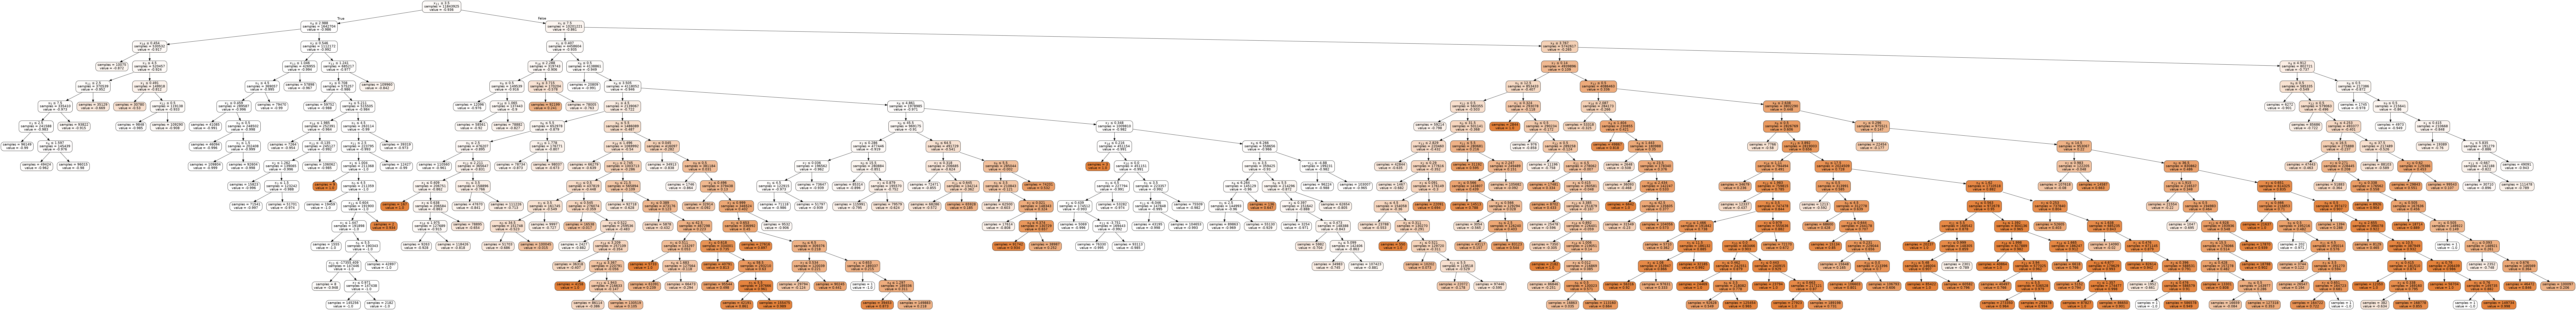

In [238]:
sub_tree_42 = clf2.best_estimator_[0, 0]
from sklearn.tree import export_graphviz, export_text
from sklearn.tree import _tree
# Visualization
# Install graphviz: https://www.graphviz.org/download/
from pydotplus import graph_from_dot_data
from IPython.display import Image
dot_data = export_graphviz(
    sub_tree_42,
    out_file=None, filled=True, rounded=True,
    special_characters=True,
    proportion=False, impurity=False, # enable them if you want
)

graph = graph_from_dot_data(dot_data)
png = graph.create_png()
# Save (optional)
from pathlib import Path
Path('output/out.png').write_bytes(png)
# Display
Image(png)

In [239]:
clf2.predict(X_test[0:100])

array([0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1])

In [240]:
clf2.predict_proba(X_test[0:100])

array([[0.55784857, 0.44215143],
       [0.67215711, 0.32784289],
       [0.03308271, 0.96691729],
       [0.23143934, 0.76856066],
       [0.04380123, 0.95619877],
       [0.94959925, 0.05040075],
       [0.02438004, 0.97561996],
       [0.31605343, 0.68394657],
       [0.05156218, 0.94843782],
       [0.90175889, 0.09824111],
       [0.47976272, 0.52023728],
       [0.18172212, 0.81827788],
       [0.19170767, 0.80829233],
       [0.03160559, 0.96839441],
       [0.0412093 , 0.9587907 ],
       [0.55726688, 0.44273312],
       [0.16918186, 0.83081814],
       [0.97178413, 0.02821587],
       [0.06487377, 0.93512623],
       [0.0763454 , 0.9236546 ],
       [0.05515133, 0.94484867],
       [0.03566345, 0.96433655],
       [0.19840662, 0.80159338],
       [0.45976054, 0.54023946],
       [0.49828298, 0.50171702],
       [0.96071569, 0.03928431],
       [0.05046047, 0.94953953],
       [0.02752305, 0.97247695],
       [0.02794152, 0.97205848],
       [0.09942886, 0.90057114],
       [0.

In [241]:
print( clf2.best_params_)

{'criterion': 'squared_error', 'learning_rate': 0.2, 'loss': 'exponential', 'max_depth': 15, 'max_features': 'log2', 'min_samples_split': 0.01, 'n_estimators': 15}


In [242]:
clf2.best_estimator_.predict_proba(X_test[9:20])

array([[0.90175889, 0.09824111],
       [0.47976272, 0.52023728],
       [0.18172212, 0.81827788],
       [0.19170767, 0.80829233],
       [0.03160559, 0.96839441],
       [0.0412093 , 0.9587907 ],
       [0.55726688, 0.44273312],
       [0.16918186, 0.83081814],
       [0.97178413, 0.02821587],
       [0.06487377, 0.93512623],
       [0.0763454 , 0.9236546 ]])

In [243]:
y = clf2.best_estimator_[0, 0].predict(X_test[9:19].values.tolist())*0
#y = gb_clf.decision_function(X_test[9:20])

rate = clf2.best_params_['learning_rate']
print(rate)
for i in range(0,10):
    sub_tree = clf2.best_estimator_[i, 0]
    y += rate*sub_tree.predict(X_test[9:19].values.tolist())
print(y)
print(gb_clf.decision_function(X_test[9:20]))
z=y
for i in range(len(z)): 
    z[i] = 1./(1+np.exp(-z[i]))
print(z)

0.2
[-1.00142414 -0.17616272  0.70904979  0.56540178  1.39031769  1.27503127
  0.05097814  0.53573336 -1.56882295  0.80121893]
[-3.44485758 -3.40501743 -2.31252031 -2.31252031 -2.31252031 -2.31252031
 -2.49793871 -2.31252031 -3.5141831  -2.31252031 -2.31252031]
[0.26866151 0.45607286 0.67019116 0.63770148 0.80064296 0.7816028
 0.51274178 0.63081933 0.17238425 0.69023516]


In [244]:
best_gbc = clf2.best_estimator_

In [245]:
n_estim = best_gbc.n_estimators

In [246]:
learning_rate = best_gbc.learning_rate
print(clf2.decision_function(X_test[9:19]))
arr = clf2.decision_function(X_test[9:19])
print(1./(1.+np.exp(-arr)))
#tree_scores = [best_gbc.estimators_[i, 0].decision_function(X_test[9:19].values.tolist()) for i in range(10)]
print(learning_rate)

[-1.1084612   0.04049668  0.75236164  0.71947607  1.71115265  1.57350442
 -0.11503855  0.79571833 -1.76962453  1.33411908]
[0.24815788 0.51012279 0.67969307 0.67249163 0.84698573 0.82828262
 0.47127204 0.68905785 0.14558903 0.79152116]
0.2


In [247]:
log_odds_predictions = []
for tree in clf2.best_estimator_:
    # For each tree, get the predicted values for each sample
    leaf_indices = tree[0].apply(X_test[9:19].values.tolist())  # Get the leaf indices for the training data
    leaf_values = tree[0].tree_.value  # Get the values at each leaf

    # Average the values for each leaf to interpret them as log odds
    predicted_log_odds = [leaf_values[leaf_indices[i]].mean() for i in range(len(X_test[9:19]))]
    log_odds_predictions.append(predicted_log_odds)

In [248]:
print(log_odds_predictions)

[[-0.797974827965047, 0.10523919053688663, 0.7307395517966582, 0.20584146461543856, 0.85455080505952, 0.7943284807752407, 0.3342366701683914, 0.897318370589695, -0.9882130385335254, -0.0917532686749045], [-0.6476593182835723, -0.2172937024751214, 0.09905495296696741, 0.15724951442866325, 0.9955744225463501, 0.7930483878936084, 0.24837010091082745, 0.4377574362455814, -0.8784356519048591, 0.9346101866922402], [-0.6657791522174451, 0.9801763345371256, -0.3402234825376031, 0.6776547880827851, 0.8025089888842221, 0.6790362356647563, -0.380980987003554, 0.6128795842290659, -0.7667834225240052, 0.9824852333397389], [-0.12117622916506365, -0.7399953422586704, 0.7764186630203619, 0.9999954126686512, 0.34139217284079265, 0.3577526717316607, -0.4787309911857413, -0.5482110445734586, -0.9532735643553762, 0.34139217284079265], [-0.6652880145625907, -0.051258289101966725, 0.2611692543690869, 0.16122260978048863, 0.8857308426641433, 0.8857719569933876, -0.08883863889754852, -0.43083330884703674, -0.

In [249]:
rate = clf2.best_params_['learning_rate']
myarr = [log_odds_predictions[i][0] for i in range(10)]
print(rate,rate*sum(myarr))
print(clf2.decision_function(X_test[9:19]))

0.2 -1.0014241442593792
[-1.1084612   0.04049668  0.75236164  0.71947607  1.71115265  1.57350442
 -0.11503855  0.79571833 -1.76962453  1.33411908]


In [250]:
print(best_gbc.estimators_.shape[0])
print(best_gbc.estimators_.shape[1])
y = []
for i in range(10):
    y0=[]
    for j in range(n_estim):
        sub_tree = clf2.best_estimator_[j, 0]
        y0.append(sub_tree.predict(X_test[9+i:10+i].values.tolist())[0])
    y.append(y0)
print(y)

15
1
[[-0.797974827965047, -0.6476593182835723, -0.6657791522174451, -0.12117622916506365, -0.6652880145625907, -0.5879764471422007, -0.3552058035480122, -0.4565457068426705, -0.38838723718840557, -0.321127984381888, -0.01767153508597537, -0.1255244807347108, -0.49681064448915446, 0.11117005988730815, -0.006348675481899642], [0.10523919053688663, -0.2172937024751214, 0.9801763345371256, -0.7399953422586704, -0.051258289101966725, -0.5870581343378104, -0.5091290607836416, -0.23071829833653287, -0.31573507530414796, 0.6849587565733604, 0.025680685391266646, -0.06325748624143493, 0.4276451595071271, 0.43414468137275103, 0.2590839790863026], [0.7307395517966582, 0.09905495296696741, -0.3402234825376031, 0.7764186630203619, 0.2611692543690869, 0.35174158294587254, 0.9884415100041978, 0.2118281040084623, 0.34224857629686734, 0.12383025633209517, 0.6314741857097891, -0.2623824052737162, -0.15960516121854812, -0.07306255441172851, 0.08013517576859648], [0.20584146461543856, 0.15724951442866325

In [251]:
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        #feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        f'x[{i}]' if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 5)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 5)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if ( "
        
        for p in path[:-1]:
            if rule != "if ( ":
                rule += " && "
            rule += str(p)
        rule += " ) "
        if class_names is None:
            rule += " return "+str(np.round(path[-1][0][0][0],30))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),20)}%)"
        rule += f";  // | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules


In [252]:
import numpy as np
from sklearn.tree import _tree
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        #feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        f'x[{i}]' if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 5)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 5)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if  "
        
        for p in path[:-1]:
            if rule != "if  ":
                rule += " if "
            rule += str(p)
        rule += "  "
        if class_names is None:
            rule += " return "+str(np.round(path[-1][0][0][0],30))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),20)}%)"
        rule += f";  // | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules

In [253]:
#print(f"double mytree{list(X_test.columns)}")
print('{')
for iestim in range(n_estim):
    print(f"    if (iestim == {iestim})")
    print('    {')
    sub_tree = clf2.best_estimator_[iestim, 0]
    rules = get_rules(sub_tree, list(X_test.columns), None)
    for r in rules:
        print("       ",r)
    print('    }')
print ('    return -9999;')
print('};')

{
    if (iestim == 0)
    {
        if  (x[11] > 3.5) if (x[5] > 7.5) if (x[4] <= 3.76702) if (x[7] > 0.13994) if (x[12] > 0.5) if (x[4] <= 2.63779) if (x[8] > 0.5) if (x[13] > 3.89195) if (x[0] > 17.5) if (x[4] > 1.61994) if (x[7] > 0.25276) if (x[4] > 1.63821) if (x[1] > 0.47586) if (x[2] > 0.39646) if (x[1] > 0.47587)   return 0.9489146067904558;  // | based on 586,578 samples
        if  (x[11] > 3.5) if (x[5] > 7.5) if (x[4] <= 3.76702) if (x[7] > 0.13994) if (x[12] > 0.5) if (x[4] <= 2.63779) if (x[8] > 0.5) if (x[13] > 3.89195) if (x[0] > 17.5) if (x[4] <= 1.61994) if (x[4] > 0.56347) if (x[4] <= 1.39238) if (x[14] > 1.99773) if (x[13] > 3.94028) if (x[3] <= 5.5)   return 0.9644748681272122;  // | based on 273,350 samples
        if  (x[11] > 3.5) if (x[5] > 7.5) if (x[4] <= 3.76702) if (x[7] > 0.13994) if (x[12] > 0.5) if (x[4] <= 2.63779) if (x[8] > 0.5) if (x[13] > 3.89195) if (x[0] > 17.5) if (x[4] <= 1.61994) if (x[4] > 0.56347) if (x[4] <= 1.39238) if (x[14] > 1.99773) if

In [254]:
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        f'x[{i}]' if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 5)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 5)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " : "
        if class_names is None:
            rule += " return "+str(np.round(path[-1][0][0][0],30))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),20)}%)"
        rule += f"  # | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules


In [255]:
print(f"def mytree( iestim,  x ) :")
for iestim in range(n_estim):
    print(f"    if iestim == {iestim}:")
    sub_tree = clf2.best_estimator_[iestim, 0]
    rules = get_rules(sub_tree, list(X_test.columns), None)
    for r in rules:
        print("       ",r)
print ('    return -9999')

def mytree( iestim,  x ) :
    if iestim == 0:
        if (x[11] > 3.5) and (x[5] > 7.5) and (x[4] <= 3.76702) and (x[7] > 0.13994) and (x[12] > 0.5) and (x[4] <= 2.63779) and (x[8] > 0.5) and (x[13] > 3.89195) and (x[0] > 17.5) and (x[4] > 1.61994) and (x[7] > 0.25276) and (x[4] > 1.63821) and (x[1] > 0.47586) and (x[2] > 0.39646) and (x[1] > 0.47587) :  return 0.9489146067904558  # | based on 586,578 samples
        if (x[11] > 3.5) and (x[5] > 7.5) and (x[4] <= 3.76702) and (x[7] > 0.13994) and (x[12] > 0.5) and (x[4] <= 2.63779) and (x[8] > 0.5) and (x[13] > 3.89195) and (x[0] > 17.5) and (x[4] <= 1.61994) and (x[4] > 0.56347) and (x[4] <= 1.39238) and (x[14] > 1.99773) and (x[13] > 3.94028) and (x[3] <= 5.5) :  return 0.9644748681272122  # | based on 273,350 samples
        if (x[11] > 3.5) and (x[5] > 7.5) and (x[4] <= 3.76702) and (x[7] > 0.13994) and (x[12] > 0.5) and (x[4] <= 2.63779) and (x[8] > 0.5) and (x[13] > 3.89195) and (x[0] > 17.5) and (x[4] <= 1.61994) and (x[4] > 0.

In [256]:
def mytree(x,y):
    return 0

In [257]:
def mygradboost (x, lerning_rate = 0.2):
    prob = 0
    for i in range (n_estim):
        prob+=lerning_rate*mytree(i, x)
    return 1. / ( 1. + np.exp( - prob ) )


In [258]:
def mybdt(x, prob):
    if mygradboost(x)>prob: return 1
    return  

In [259]:
iestim = 9
sub_tree = clf2.best_estimator_[iestim, 0]
y = sub_tree.predict(X_test[9:19].values.tolist())
print(y)

myf = [mytree(iestim, X_test[9+i:10+i].values.tolist()[0]) for i in range(10)]
print(myf)

[-0.32112798  0.68495876  0.12383026  0.47211693  0.47911268  0.47911268
  0.44569592 -0.09638419 -0.68939923 -0.00290738]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [260]:
iestim = 9
sub_tree = clf2.best_estimator_
y = sub_tree.predict_proba(X_test[9:19].values.tolist())
print(y)

myf = [mygradboost(X_test[9+i:10+i].values.tolist()[0]) for i in range(10)]
print(myf)

[[0.90175889 0.09824111]
 [0.47976272 0.52023728]
 [0.18172212 0.81827788]
 [0.19170767 0.80829233]
 [0.03160559 0.96839441]
 [0.0412093  0.9587907 ]
 [0.55726688 0.44273312]
 [0.16918186 0.83081814]
 [0.97178413 0.02821587]
 [0.06487377 0.93512623]]
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


/home/yoren/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


In [261]:
input_x = [ X_test[9:19].values.tolist()[0][i] for i in range(len(X_test[9:19].values.tolist()[0])) ]
print(input_x)

[11.0, 2.623076876006169, 3.1757121086120605, 3.0, 3.05887508392334, 9.0, 2.0, 0.0156252961605787, 1.0, 1.0, 1.0, 5.0, 0.0, 1.8304104026191226, 7.430532297438283]


In [262]:
iestim = 9
sub_tree = clf2.best_estimator_
y = sub_tree.predict_proba(X_test[9:19].values.tolist())
y = [y[i][1] for i in range(len(y))]
print(y)

myf = [mygradboost(X_test[9+i:10+i].values.tolist()[0]) for i in range(10)]
print(myf)

[0.09824111144116529, 0.5202372781082822, 0.8182778808203596, 0.8082923328775257, 0.9683944051870396, 0.9587906997945581, 0.44273312088484673, 0.830818135678926, 0.028215871245586808, 0.9351262315024993]
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


/home/yoren/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


In [263]:
column_headers = list(X_test.columns.values)
print(column_headers)
print(len(column_headers))

['centrality', 'pt', 'ecore', 'n0', 'disp', 'npe0', 'sector', 'prob', 'emcdphi', 'emcdz', 'Q', 'e/p', 'chi2/npe0', 'disp2', 'centr+pt']
15
